In [2]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

### load lemmatized speeches

In [2]:
with open('speeches-lemmatized.pkl', 'rb') as f:
    df = pickle.load(f)

### replace empty heading entries with ''

In [3]:
df[['major_heading', 'minor_heading']] = df[['major_heading', 'minor_heading']].fillna(value='')

### combine major and minor headings

In [4]:
df['minor_heading'] = df['minor_heading'].str.strip()
df['major_heading'] = df['major_heading'].str.strip()
df['heading'] = df['major_heading'] + ' ' + df['minor_heading']
df['heading'] = df['heading'].str.strip()

### aggregate entries

rows with identical date, heading, and display_as index values are combined together: speeches by string joining with spaces, lemmas by list concatenation

In [5]:
df_agg = df.groupby(['date', 'heading', 'mnis_id']).agg({'speech': lambda x: " ".join(x), 'lemmas': 'sum'})

In [6]:
df_agg

speech  \
date       heading                                           mnis_id                                                      
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 117      I congratulate the hon Member for Derby North ...   
                                                             1388     I join the Prime Minister and the Leader of th...   
                                                             14       I should like to express my gratitude to the v...   
                                                             1400     On a point of order, Mr Speaker. Is it in orde...   
                                                             1411     The right hon Gentleman has referred to the si...   
...                                                                                                                 ...   
2019-11-05 Valedictory Debate                                432      It seems only the blink of an eye since my hon...   
                                                             4455     On a point of order, Madam Deputy Speaker. As ...   
                                                             4524     I might have guessed, Madam Deputy Speaker. I ...   
                                                             553      I wanted to allow others to go first, but than...   
                                                             88       I was first elected to this place as the first...   

                                                                                                                 lemmas  
date       heading                                           mnis_id                                                     
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 117      [congratulate, hon, member, derby, north, chri...  
                                                             1388     [join, prime, minister, leader, opposition, pa...  
                                                             14       [like, express, gratitude, voter, wokingham, r...  
                                                             1400     [point, order, mr, speaker, order, prime, mini...  
                                                             1411     [right, hon, gentleman, refer, situation, scot...  
...                                                                                                                 ...  
2019-11-05 Valedictory Debate                                432      [blink, eye, hon, friends, member, eale, north...  
                                                             4455     [point, order, madam, deputy, speaker, point, ...  
                                                             4524     [guess, madam, deputy, speaker, course, abide,...  
                                                             553      [want, allow, thank, madam, deputy, speaker, e...  
                                                             88       [elect, place, conservative, year, sit, consti...  

[240797 rows x 2 columns]

In [7]:
with open('speeches-lemmatized-agg.pkl', 'wb') as f:
    pickle.dump(df_agg, f)

### make n_grams

In [8]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# up to 6 long
max_n_gram = 6

ngram_models = {}

texts = df_agg.lemmas.values

for n in np.arange(2, max_n_gram+1):
    ngram_models[n] = Phrases(texts,
                              min_count=300, # individual words and n_gram used at least 300 times
                              threshold=30, # score produced by Phrases - manual testing, 25 a conservative balance
                              connector_words=ENGLISH_CONNECTOR_WORDS).freeze() # no more updates - freezing here is faster
    texts = [ngram_models[n][text] for text in texts]
    print(f'done {n}-gram model')

/home/bendennes/miniconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


done 2-gram model
done 3-gram model
done 4-gram model
done 5-gram model
done 6-gram model


In [9]:
df_agg['lemmas_ngrams'] = texts
df_agg = df_agg.drop(columns='lemmas')

In [10]:
# phrases = ngram_models[6].export_phrases()
# sorted_phrases_asc = dict(sorted(phrases.items(), key=lambda item: item[1]))
# sorted_phrases_desc = dict(sorted(phrases.items(), key=lambda item: item[1], reverse=True))

## remove lemmas present in >X% speeches

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

dummy = lambda x: x

cv = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    token_pattern=None,
    max_df = 0.20
    )

texts = df_agg.lemmas_ngrams.values
cv.fit(texts)
print("fit cv")

stopwords = list(cv.stop_words_) + ['', ' ']
texts = [[w for w in text if w not in stopwords] for text in texts]
print('found stopwords and removed from texts (lists of lemmas)')

fit cv
found stopwords and removed from texts (lists of lemmas)


In [12]:
stopwords

['time',
 'say',
 'right',
 'point',
 'want',
 'need',
 'people',
 'member',
 'good',
 'issue',
 'hon',
 'come',
 'give',
 'year',
 'country',
 'support',
 'secretary_state',
 'work',
 'agree',
 'minister',
 'ensure',
 'debate',
 'way',
 'government',
 'house',
 'know',
 'go',
 'friend',
 'take',
 '',
 ' ']

* In parliament convention is not to refer to other MPs by name, or using second person pronouns. This leads to stopwords like 'right', 'hon', 'member', 'friend' (e.g. "does my right hon. friend agree that..." vs "Theresa May, do you agree that...") and 'minister', ("the minister for vaccines"
* Others related to typical non-topical political rhetoric, e.g. 'government', 'people', 'need', 'work'
* Others related to parliamentary procedure, e.g. 'time', 'house', 'year'

In [13]:
# separate dataframe for stopword removal - quicker testing due to time of n-grams creation
df_agg_sw = df_agg.copy() # sw is version including stopwords
df_agg['lemmas_ngrams'] = texts

In [14]:
with open('speeches-lemmatized-agg-ngrams.pkl', 'wb') as f:
    pickle.dump(df_agg, f)

### remove speeches with fewer than 40 lemmas

In [3]:
with open('speeches-lemmatized-agg-ngrams.pkl', 'rb') as f:
    df_agg = pickle.load(f)

In [4]:
lengths = df_agg.lemmas_ngrams.apply(len).values

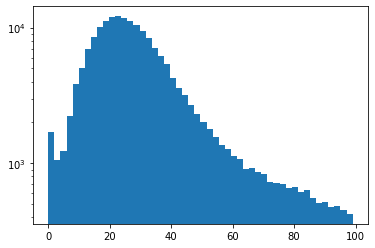

In [5]:
hist, bin_edges, _ = plt.hist(lengths[lengths < 100], bins=50)
plt.yscale('log')
plt.show()

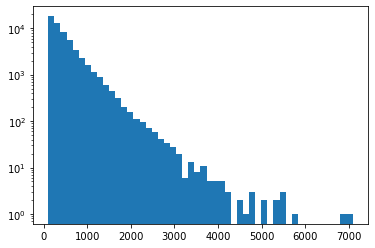

In [9]:
hist, bin_edges, _ = plt.hist(lengths[lengths > 100], bins=50)
plt.yscale('log')
plt.show()

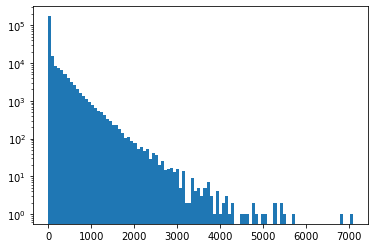

In [4]:
hist, bin_edges, _ = plt.hist(lengths, bins=100)
plt.yscale('log')
plt.show()

In [5]:
wordcount_under_40_lemmas = df_agg.iloc[lengths < 40].speech.str.split().apply(len).values

In [11]:
np.max(wordcount_under_40_lemmas)

189

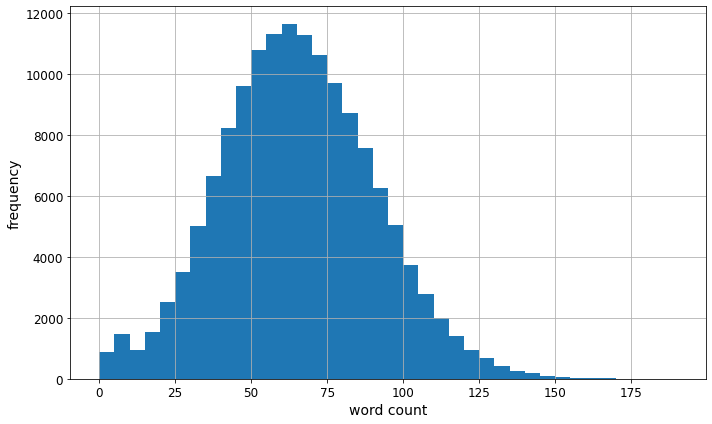

In [13]:
plt.figure(figsize=(10,6))
# plt.hist(wordcount_under_40_lemmas, bins=25)
plt.hist(wordcount_under_40_lemmas, bins=np.arange(0,191,5))
# plt.title('Word count of speeches with fewer than 40 lemmas', fontsize=16)
# plt.savefig('figures/wordcount_under_40_lemmas.png')
plt.xlabel('word count', fontsize=14)
plt.ylabel('frequency', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.tight_layout()
plt.savefig('figures/wordcount_under_40_lemmas.png')
plt.show()

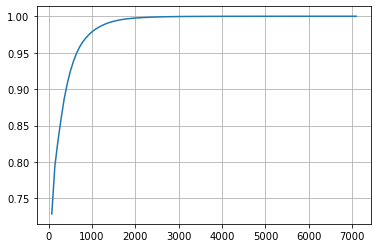

In [17]:
plt.plot(bin_edges[1:], np.cumsum(hist / np.sum(hist)))
plt.grid()

In [27]:
for x in df_agg[lengths < 40].sample(5).speech.values:
    print(x,'\n')

Will the hon Gentleman give way? Will the hon Gentleman give way? We dealt with this in some detail in the Bill Committee, and I recognise that it is one of the principal issues that has been discussed today. It is already clear that someone can express a view — a personal opinion — to which no one would have any objection, but if they did so in a way that bullied or stigmatised, or in any way went beyond what is reasonably acceptable, they would be going too far. This is no different from many of the issues that teachers deal with every single day. On all those issues, yes, we issue guidance, but we never do anything as prescriptive as putting into primary legislation certain rights and responsibilities that would be unacceptable in any other field. 

There people are dying, yet this goes on and on. People want closure; they know they are coming to the end of their lives, and that they will not get that closure. 

May I compliment the Prime Minister on her stamina, and thank her for m

In [19]:
# no. entries in df
total_l = len(df_agg)

# minimum no. lemmas for passed speeches
t = 40

# filter
# again, separate dataframe for quicker testing at memory expense
df_agg_t = df_agg[df_agg.lemmas_ngrams.apply(len) >= t]

# proportion entries retained
len(df_agg_t) / total_l

0.39333131226717943

In [20]:
df_agg_t

speech  \
date       heading                                           mnis_id                                                      
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 117      I congratulate the hon Member for Derby North ...   
                                                             1388     I join the Prime Minister and the Leader of th...   
                                                             14       I should like to express my gratitude to the v...   
                                                             1446     On a point of order, Mr Speaker. You said earl...   
                                                             1453     I want to pick the right hon Gentleman up on a...   
...                                                                                                                 ...   
2019-11-05 Valedictory Debate                                432      It seems only the blink of an eye since my hon...   
                                                             4455     On a point of order, Madam Deputy Speaker. As ...   
                                                             4524     I might have guessed, Madam Deputy Speaker. I ...   
                                                             553      I wanted to allow others to go first, but than...   
                                                             88       I was first elected to this place as the first...   

                                                                                                          lemmas_ngrams  
date       heading                                           mnis_id                                                     
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 117      [congratulate, derby, north, chris, williamson...  
                                                             1388     [join, prime_minister, leader, opposition, pay...  
                                                             14       [like, express, gratitude, voter, wokingham, r...  
                                                             1446     [point_order_mr_speaker, early, sake, accuracy...  
                                                             1453     [pick, gentleman, different, talk, health, spe...  
...                                                                                                                 ...  
2019-11-05 Valedictory Debate                                432      [blink, eye, friends, eale, north, stephen, po...  
                                                             4455     [order, madam_deputy_speaker, order, seek, gui...  
                                                             4524     [guess, madam_deputy_speaker, course, abide, s...  
                                                             553      [allow, thank, madam_deputy_speaker, elect, mi...  
                                                             88       [elect, place, conservative, sit, constituency...  

[94713 rows x 2 columns]

<AxesSubplot:>

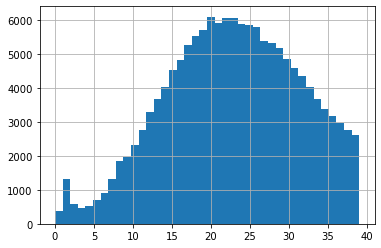

In [21]:
df_agg[df_agg.lemmas_ngrams.apply(len) < t].lemmas_ngrams.apply(len).hist(bins=t)

In [22]:
with open('speeches-lemmatized-agg-ngrams-long.pkl', 'wb') as f:
    pickle.dump(df_agg_t, f)